{/* cspell:ignore hivqe mcscf CASCI */}

# Compute Dissociation PES curve for Li2S (20Q) and FeP-NO (44Q) with Qunova HiVQE

*Usage estimate (NOTE: This is an estimate only. Your runtime may vary.)*

* Li2S: 5 minutes QPU time on `ibm_marrakesh`
* FeP-NO: 5 minutes QPU time on `ibm_marrakesh`

## Background

Accurately calculating chemical reaction energies is crucial for scientific advancements in materials science, chemical engineering, drug discovery, and other fields. Among various chemical systems, the Li-S system has garnered significant interest for understanding and developing new battery compositions. This tutorial provides hands-on experience in calculating the Li-S bond dissociation potential energy surface (PES) of a $Li_2S$ system by removing one lithium atom using HiVQE calculations. The results can be compared with reference calculations (CASCI) as well as classical methods like Hartree-Fock (HF) for a 20-qubit problem.

## Requirements

Install the following dependencies to run the code in this tutorial.

In [ ]:
!pip install qiskit-ibm-catalog
!pip install qiskit_ibm_runtime
!pip install pyscf
!pip install numpy
!pip install matplotlib

## Setup

To run this tutorial, import `qunova/hivqe-chemistry` function via `QiskitFunctionCatalog`. You need an IBM Quantum® Premium Plan account with a license from Qunova to run this function.

In [ ]:
from qiskit_ibm_catalog import QiskitFunctionsCatalog
from qiskit_ibm_runtime import QiskitRuntimeService
from pyscf import gto, scf, mcscf
import matplotlib.pyplot as plt
import pprint

service = QiskitRuntimeService()
catalog = QiskitFunctionsCatalog()
hivqe = catalog.load("qunova/hivqe-chemistry")

## Part 1: Li2S (20Q)

### Step 1: Map classical inputs to a quantum problem

Define $Li_2S$ geometries in dictionary format for different bond distance of Li-S to calculate PES curve. These geometries are optimized using B3LYP/631g calculations.

In [2]:
str_geometries = {
    "1.51": "S -1.239044 0.671232 -0.030374; Li -1.506327 0.432403 -1.498949; Li -0.899996 0.973348 1.826768",
    "1.91": "S -1.215858 0.692272 0.099232; Li -1.553305 0.390283 -1.758043; Li -0.876205 0.994426 1.956257",
    "2.40": "S -1.741432 0.680397 0.346702; Li -0.529307 0.488006 -1.729343; Li -1.284307 0.989409 2.177209",
    "3.10": "S -2.347450 0.657089 0.566194; Li -0.199353 0.527517 -1.665148; Li -1.008243 0.973206 1.893522",
    "3.80": "S -2.707255 0.674298 0.909161; Li 0.079218 0.552012 -1.671656; Li -0.927010 0.931502 1.557063",
    "4.50": "S -2.913363 0.709175 1.276987; Li 0.368656 0.559989 -1.798088; Li -1.010340 0.888647 1.315670",
}
str_geometries

{'1.51': 'S -1.239044 0.671232 -0.030374; Li -1.506327 0.432403 -1.498949; Li -0.899996 0.973348 1.826768',
 '1.91': 'S -1.215858 0.692272 0.099232; Li -1.553305 0.390283 -1.758043; Li -0.876205 0.994426 1.956257',
 '2.40': 'S -1.741432 0.680397 0.346702; Li -0.529307 0.488006 -1.729343; Li -1.284307 0.989409 2.177209',
 '3.10': 'S -2.347450 0.657089 0.566194; Li -0.199353 0.527517 -1.665148; Li -1.008243 0.973206 1.893522',
 '3.80': 'S -2.707255 0.674298 0.909161; Li 0.079218 0.552012 -1.671656; Li -0.927010 0.931502 1.557063',
 '4.50': 'S -2.913363 0.709175 1.276987; Li 0.368656 0.559989 -1.798088; Li -1.010340 0.888647 1.315670'}

HiVQE calculations will be performed with the options defined below. Using sto3g basis for $Li_2S$, there are 19 spatial orbitals with 22 electrons. To run (10o,10e) case with HiVQE calculation, you can define 10 active orbitals and six frozen orbitals. At each iteration, 100 shots will be used to sample electron configuration generated by the ExcitationPreserving quantum circuit (`epa`) with `circular` entanglement and two repetitions (`reps`). The maximum number of iteration is set to be 30 to ensure termination of iteration with energy convergence.

In [ ]:
molecule_options = {
    "basis": "sto3g",
    "active_orbitals": list(range(5, 15)),
    "frozen_orbitals": list(range(5)),
}

hivqe_options = {
    "shots": 100,
    "max_iter": 30,
    "ansatz": "epa",
    "ansatz_entanglement": "circular",
    "ansatz_reps": 2,
}

### Step 2 and 3: Optimize problem for quantum hardware execution and execute using the HiVQE Chemistry function

Set up the `for` loop to run HiVQE calculations with geometries with options defined below. Jobs are submitted in the `for` loop. In this tutorial, you will submit six geometries and retrieve results when they are all completed. In the main function run, you need to define the `max_states` and `max_expansion_states` to control the maximum size of the subspace matrix and to control how many states can be generated using classical CI expansion methods per iteration. The function job ids will be stored in the dictionary with each geometry label to further track and process the ouptut.

In [ ]:
info_jobid = {}
for dis, geom in str_geometries.items():
    hivqe_run = hivqe.run(
        geometry=geom,
        backend_name="",
        instance="",
        max_states=40000,
        max_expansion_states=100,
        molecule_options=molecule_options,
        hivqe_options=hivqe_options,
    )
    status = hivqe_run.status()
    info_jobid[dis] = hivqe_run.job_id
print(info_jobid)

{'1.51': 'de3b8818-c9db-4fa3-a3c2-d51551c2dfaf', '1.91': '55d9467a-fc85-49a8-9bc6-8f6990e421e5', '2.40': '415112b3-69ff-4d53-8b10-cb4e3be68c9e', '3.10': 'ef67b600-3887-4225-b872-e354dfdf8454', '3.80': 'b16d3502-a9e4-4560-9775-852e9d07e70f', '4.50': '0c0bffc7-af77-4a56-a656-2a2610c991d6'}


Let's check whether all jobs are still running or completed.

In [40]:
completed_jobs_num = 0
running_jobs_num = 0
completed_jobs = {}
for i, info in enumerate(info_jobid.items()):
    dis, job_id = info
    submitted_job = catalog.get_job_by_id(job_id)
    stat = submitted_job.status()
    print(dis, submitted_job.job_id, stat)
    if stat == "DONE":
        completed_jobs_num += 1
        completed_jobs[dis] = submitted_job
    if (stat == "RUNNING") or (stat == "QUEUED"):
        running_jobs_num += 1

print(
    f"Completed {completed_jobs_num} job, Running or Queued {running_jobs_num} job"
)

1.51 de3b8818-c9db-4fa3-a3c2-d51551c2dfaf DONE
1.91 55d9467a-fc85-49a8-9bc6-8f6990e421e5 DONE
2.40 415112b3-69ff-4d53-8b10-cb4e3be68c9e DONE
3.10 ef67b600-3887-4225-b872-e354dfdf8454 DONE
3.80 b16d3502-a9e4-4560-9775-852e9d07e70f DONE
4.50 0c0bffc7-af77-4a56-a656-2a2610c991d6 DONE
Completed 6 job, Running or Queued 0 job


Once all jobs are completed, let's retrieve all calculation results.

In [ ]:
hivqe_result = {}
if len(info_jobid) == completed_jobs_num:
    print("All jobs are completed")
    for i, job in enumerate(completed_jobs.items()):
        dis, cal = job
        print(dis, cal.result()["energy"])
        hivqe_result[str(dis)] = cal.result()["energy"]

All jobs are completed
1.51 -407.8944801731773
1.91 -407.9800570932916
2.40 -407.9372992999806
3.10 -407.86278336000134
3.80 -407.83092972296157
4.50 -407.82971011225766


In [ ]:
pprint.pprint(hivqe_result)

{'1.51': -407.8944801731773,
 '1.91': -407.9800570932916,
 '2.40': -407.9372992999806,
 '3.10': -407.86278336000134,
 '3.80': -407.83092972296157,
 '4.50': -407.82971011225766}


The entire QPU runtime used in the job can be tracked by logging in to [quantum.ibm.com](https://quantum.ibm.com) and viewing submitted jobs with the `qunova-chemistry-hivqe` tag.

### Step 4: Post-process and compare with classical methods

Classical reference calculation (CASCI) can be conducted for (10o,10e) to validate HiVQE results.

In [ ]:
str_geometries = {
    "1.31": "S -1.250686 0.660708 -0.095168; Li -1.482812 0.453464 -1.369406; Li -0.911870 0.962810 1.762020",
    "1.41": "S -1.244856 0.665971 -0.062773; Li -1.494574 0.442933 -1.434177; Li -0.905937 0.968078 1.794395",
    "1.51": "S -1.239044 0.671232 -0.030374; Li -1.506327 0.432403 -1.498949; Li -0.899996 0.973348 1.826768",
    "1.61": "S -1.233245 0.676492 0.002027; Li -1.518073 0.421873 -1.563722; Li -0.894049 0.978617 1.859141",
    "1.71": "S -1.227453 0.681752 0.034429; Li -1.529816 0.411343 -1.628496; Li -0.888099 0.983887 1.891513",
    "1.81": "S -1.221659 0.687012 0.066831; Li -1.541558 0.400813 -1.693270; Li -0.882150 0.989157 1.923885",
    "1.91": "S -1.215858 0.692272 0.099232; Li -1.553305 0.390283 -1.758043; Li -0.876205 0.994426 1.956257",
    "2.01": "S -1.209887 0.697544 0.131599; Li -1.565136 0.379748 -1.822800; Li -0.870344 0.999691 1.988646",
    "2.11": "S -1.203945 0.702813 0.163973; Li -1.576953 0.369214 -1.887560; Li -0.864469 1.004956 2.021033",
    "2.21": "S -1.198023 0.708081 0.196350; Li -1.588760 0.358680 -1.952322; Li -0.858584 1.010221 2.053417",
    "2.30": "S -1.365426 0.717714 0.367060; Li -0.689401 0.458925 -1.828368; Li -1.500219 0.981173 2.255876",
    "2.31": "S -1.192118 0.713348 0.228731; Li -1.600559 0.348146 -2.017085; Li -0.852690 1.015488 2.085800",
    "2.40": "S -1.741432 0.680397 0.346702; Li -0.529307 0.488006 -1.729343; Li -1.284307 0.989409 2.177209",
    "2.50": "S -1.885961 0.669986 0.365815; Li -0.461563 0.499084 -1.695846; Li -1.207523 0.988741 2.124599",
    "2.60": "S -1.977163 0.665155 0.389784; Li -0.416654 0.504966 -1.683655; Li -1.161229 0.987690 2.088439",
    "2.70": "S -2.063642 0.661518 0.418977; Li -0.367600 0.510505 -1.676408; Li -1.123804 0.985788 2.051998",
    "2.80": "S -2.141072 0.659218 0.451663; Li -0.323153 0.515056 -1.673046; Li -1.090821 0.983538 2.015951",
    "2.90": "S -2.212097 0.657968 0.487535; Li -0.281989 0.518909 -1.672407; Li -1.060960 0.980935 1.979440",
    "3.00": "S -2.281477 0.657123 0.525155; Li -0.239607 0.523326 -1.668669; Li -1.033963 0.977363 1.938081",
    "3.10": "S -2.347450 0.657089 0.566194; Li -0.199353 0.527517 -1.665148; Li -1.008243 0.973206 1.893522",
    "3.20": "S -2.410882 0.657532 0.608912; Li -0.157788 0.532069 -1.659971; Li -0.986376 0.968211 1.845627",
    "3.30": "S -2.470306 0.658818 0.654893; Li -0.118007 0.536237 -1.656311; Li -0.966733 0.962757 1.795986",
    "3.40": "S -2.525776 0.660762 0.702910; Li -0.078312 0.540189 -1.654076; Li -0.950958 0.956861 1.745734",
    "3.50": "S -2.576885 0.663376 0.752788; Li -0.039076 0.543706 -1.654536; Li -0.939085 0.950730 1.696316",
    "3.60": "S -2.623930 0.666534 0.803853; Li 0.000274 0.546839 -1.657697; Li -0.931390 0.944439 1.648412",
    "3.70": "S -2.667364 0.670217 0.856250; Li 0.039572 0.549616 -1.663265; Li -0.927254 0.937980 1.601583",
    "3.80": "S -2.707255 0.674298 0.909161; Li 0.079218 0.552012 -1.671656; Li -0.927010 0.931502 1.557063",
    "3.90": "S -2.744005 0.678718 0.962425; Li 0.119268 0.554073 -1.682595; Li -0.930310 0.925021 1.514738",
    "4.00": "S -2.777891 0.683415 1.015798; Li 0.159751 0.555810 -1.696024; Li -0.936907 0.918587 1.474794",
    "4.10": "S -2.809179 0.688333 1.069057; Li 0.200678 0.557234 -1.711873; Li -0.946546 0.912245 1.437385",
    "4.20": "S -2.838194 0.693443 1.122205; Li 0.242066 0.558401 -1.729770; Li -0.958918 0.905968 1.402134",
    "4.30": "S -2.864984 0.698619 1.174415; Li 0.283858 0.559186 -1.750539; Li -0.973920 0.900007 1.370693",
    "4.40": "S -2.889984 0.703887 1.226140; Li 0.326068 0.559728 -1.773231; Li -0.991131 0.894196 1.341660",
    "4.50": "S -2.913363 0.709175 1.276987; Li 0.368656 0.559989 -1.798088; Li -1.010340 0.888647 1.315670",
}

In [ ]:
rhf_result = {}
casci_result = {}

cas_list = molecule_options["active_orbitals"]
distance_ref = []
for dis, geom in str_geometries.items():
    distance_ref.append(dis)
    mole = gto.M(atom=geom, basis=molecule_options["basis"])
    mole.verbose = 0
    # RHF energy
    mf = scf.RHF(mole).run()
    mo_occ = mf.mo_occ
    num_elecs_as = int(sum([mo_occ[idx] for idx in cas_list]))

    rhf_result[str(dis)] = mf.e_tot
    # CASCI energy
    casci_solver = mcscf.CASCI(mf, len(cas_list), num_elecs_as)
    orbs = mcscf.addons.sort_mo(casci_solver, mf.mo_coeff, cas_list, base=0)
    casci_solver.kernel(orbs)
    casci_result[str(dis)] = casci_solver.e_tot
    print(
        f"d={dis:4.3} RHF Energy: {mf.e_tot:14.10}, CASCI Energy: {casci_solver.e_tot:14.10}"
    )

d=1.3  RHF Energy:   -407.7137006, CASCI Energy:   -407.7193917
d=1.4  RHF Energy:   -407.8183196, CASCI Energy:   -407.8245211
d=1.5  RHF Energy:   -407.8878013, CASCI Energy:   -407.8944802
d=1.6  RHF Energy:   -407.9315356, CASCI Energy:   -407.9385663
d=1.7  RHF Energy:   -407.9569034, CASCI Energy:   -407.9641258
d=1.8  RHF Energy:   -407.9693681, CASCI Energy:   -407.9766313
d=1.9  RHF Energy:   -407.9728592, CASCI Energy:   -407.9800572
d=2.0  RHF Energy:   -407.9701684, CASCI Energy:   -407.9772549
d=2.1  RHF Energy:   -407.9632701, CASCI Energy:   -407.9702381
d=2.2  RHF Energy:   -407.9535584, CASCI Energy:   -407.9604007
d=2.3  RHF Energy:   -407.9420173, CASCI Energy:   -407.9487043
d=2.3  RHF Energy:   -407.9420156, CASCI Energy:   -407.9487024
d=2.4  RHF Energy:   -407.9297216, CASCI Energy:   -407.9372993
d=2.5  RHF Energy:      -407.9172, CASCI Energy:   -407.9261859
d=2.6  RHF Energy:   -407.9061139, CASCI Energy:    -407.915961
d=2.7  RHF Energy:   -407.8937118, CASCI

### Plotting the dissociation curve for Li\_2S

Let's plot and compare HiVQE results with HF and CASCI.
You can observe that all HiVQE calculations are well-matched with the classical reference result (CASCI).

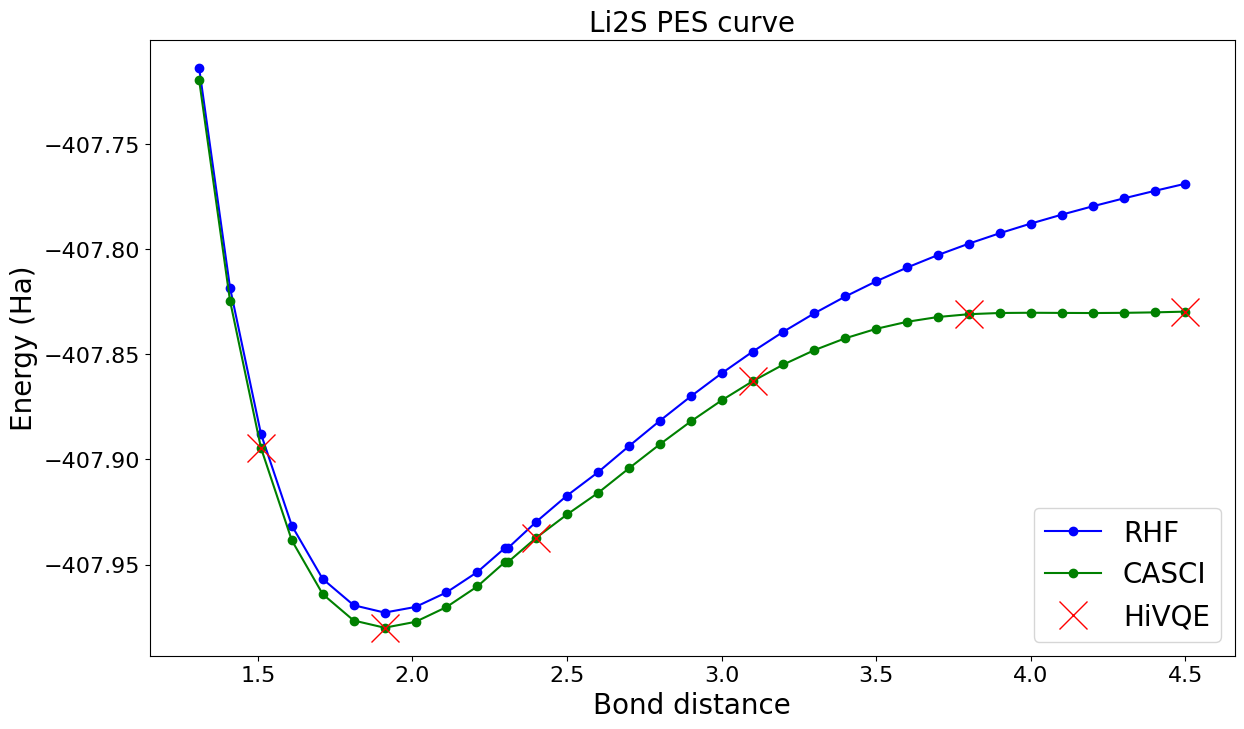

In [ ]:
fig, ax = plt.subplots(1, 1)
hf_energy = [v for key, v in rhf_result.items()]
casci_energy = [v for key, v in casci_result.items()]
hivqe_energy = [v for key, v in hivqe_result.items()]
distance_ref = [float(key) for key, v in rhf_result.items()]
distance = [float(key) for key, v in hivqe_result.items()]

ax.plot(distance_ref, hf_energy, "-o", label="RHF", c="blue")
ax.plot(distance_ref, casci_energy, "-o", label="CASCI", c="green")
ax.plot(distance, hivqe_energy, "x", label="HiVQE", c="red", markersize=20)
ax.legend(fontsize=20)
ax.tick_params("both", labelsize=16)
ax.set_xlabel("Bond distance (angstrom)", size=20)
ax.set_ylabel("Energy (Ha)", size=20)
ax.set_title("Li2S PES curve", size=20)
fig.set_size_inches(14, 8)

## Part 2: FeP-NO (44Q)

### Step 1: Map classical inputs to a quantum problem

Define the options for HiVQE calculations

In [ ]:
molecule_options = {
    "basis": "631g*",
    "active_orbitals": list(range(90, 112, 1)),
    "frozen_orbitals": list(range(0, 90, 1)),
    "charge": -1,
}

hivqe_options = {
    "shots": 2000,
    "max_iter": 40,
    "ansatz": "epa",
    "ansatz_entanglement": "linear",
    "ansatz_reps": 2,
    "amplitude_screening_tolerance": 1e-6,
}

Define FeP-NO geometries in dictionary format for different bond distances of Fe-N to calculate PES curve.

In [ ]:
geometry_1_75 = """
Fe     9.910596    31.534095     1.798088
N     10.557481    31.888419    -0.055204
N     11.823496    31.255002     2.384659
N      9.292831    30.783362     3.568730
N      8.036805    31.418327     1.124265
C      9.784765    32.177349    -1.158798
C     10.612656    32.501029    -2.296868
C     11.903375    32.404043    -1.876832
C     11.859093    32.028943    -0.483750
C     12.965737    31.464698     1.641427
C     14.146517    31.236323     2.440231
C     13.713061    30.885870     3.681911
C     12.268752    30.896411     3.634891
C     10.067717    30.486167     4.664747
C      9.246224    30.053411     5.772052
C      7.957075    30.082846     5.336488
C      7.995710    30.538421     3.967046
C      6.900258    31.104497     1.836595
C      5.722470    31.251707     1.015333
C      6.148430    31.668586    -0.207993
C      7.587039    31.767438    -0.130483
C      8.399453    32.134197    -1.192329
H      7.912872    32.388031    -2.131079
C     12.984883    31.836053     0.306093
H     13.955948    31.977044    -0.162626
C     11.453768    30.560663     4.708020
H     11.940677    30.298823     5.644352
C      6.877071    30.697580     3.164102
H      5.907240    30.476797     3.603674
H     12.813946    32.569160    -2.441577
H     10.236332    32.758110    -3.280309
H     15.164312    31.335191     2.080201
H     14.299625    30.629109     4.556760
H      9.626524    29.758225     6.743433
H      7.053076    29.823583     5.875809
H      4.709768    31.058315     1.350561
H      5.561898    31.886355    -1.093106
N      9.832739    33.209042     2.298783
O      9.346337    34.075996     1.606023
"""

geometry_2_00 = """
Fe     9.917990    31.445558     1.778346
N     10.556809    31.866188    -0.055498
N     11.814089    31.227003     2.372666
N      9.297875    30.758246     3.550104
N      8.043584    31.397768     1.120485
C      9.784831    32.164652    -1.160219
C     10.611624    32.501801    -2.293514
C     11.902858    32.406547    -1.875160
C     11.859552    32.017818    -0.486307
C     12.960503    31.454432     1.636717
C     14.140770    31.242960     2.439615
C     13.708543    30.884151     3.678983
C     12.266351    30.874173     3.627468
C     10.070264    30.465070     4.655102
C      9.247247    30.053101     5.766681
C      7.958085    30.091201     5.332866
C      7.998432    30.529979     3.958727
C      6.901428    31.093932     1.833807
C      5.723289    31.255057     1.016540
C      6.151314    31.670649    -0.206350
C      7.589736    31.755538    -0.133074
C      8.400230    32.124963    -1.194447
H      7.913264    32.386655    -2.130914
C     12.983905    31.827747     0.302415
H     13.955696    31.979687    -0.161365
C     11.454251    30.533644     4.698234
H     11.941002    30.276716     5.636156
C      6.877444    30.689985     3.159940
H      5.907605    30.480118     3.604825
H     12.813105    32.581608    -2.437367
H     10.233725    32.768337    -3.273979
H     15.157796    31.357524     2.082132
H     14.295001    30.638320     4.557047
H      9.626721    29.768762     6.741623
H      7.051752    29.847502     5.875478
H      4.709710    31.071712     1.354640
H      5.565103    31.898376    -1.089333
N      9.840508    33.353531     2.373019
O      9.344561    34.158205     1.637232
"""

geometry_5_00 = """
Fe     9.918629    31.289202     1.717339
N     10.542914    31.832173    -0.080685
N     11.795572    31.199413     2.341831
N      9.294593    30.741247     3.513929
N      8.042689    31.359481     1.087282
C      9.775254    32.111817    -1.200449
C     10.600219    32.479101    -2.319680
C     11.891090    32.425876    -1.887580
C     11.847694    32.024341    -0.507342
C     12.945734    31.464689     1.611366
C     14.116395    31.289997     2.423572
C     13.685777    30.915122     3.663719
C     12.252381    30.861042     3.608186
C     10.062170    30.463021     4.634102
C      9.236749    30.104333     5.755782
C      7.945687    30.161198     5.324720
C      7.989641    30.552269     3.941498
C      6.892881    31.087489     1.815829
C      5.722676    31.253502     1.001149
C      6.153153    31.631057    -0.238233
C      7.586010    31.695401    -0.179773
C      8.390724    32.047572    -1.247553
H      7.903308    32.291586    -2.187969
C     12.973334    31.849872     0.283741
H     13.944682    32.031190    -0.169145
C     11.447158    30.518591     4.678739
H     11.934423    30.277429     5.619969
C      6.864795    30.711643     3.146118
H      5.893357    30.532078     3.599511
H     12.800139    32.636412    -2.439296
H     10.224017    32.743662    -3.301293
H     15.131785    31.441247     2.076257
H     14.273933    30.694315     4.546802
H      9.612512    29.848040     6.739754
H      7.036117    29.960530     5.879248
H      4.707408    31.099933     1.347803
H      5.564992    31.851940    -1.121294
N      9.666041    36.091609     3.085945
O      9.598728    37.226756     3.411299
"""

str_geometries = {
    "1.75": geometry_1_75,
    "2.00": geometry_2_00,
    "5.00": geometry_5_00,
}


hivqe_result = {}

{'5.0': '\nFe     9.918629    31.289202     1.717339\nN     10.542914    31.832173    -0.080685\nN     11.795572    31.199413     2.341831\nN      9.294593    30.741247     3.513929\nN      8.042689    31.359481     1.087282\nC      9.775254    32.111817    -1.200449\nC     10.600219    32.479101    -2.319680\nC     11.891090    32.425876    -1.887580\nC     11.847694    32.024341    -0.507342\nC     12.945734    31.464689     1.611366\nC     14.116395    31.289997     2.423572\nC     13.685777    30.915122     3.663719\nC     12.252381    30.861042     3.608186\nC     10.062170    30.463021     4.634102\nC      9.236749    30.104333     5.755782\nC      7.945687    30.161198     5.324720\nC      7.989641    30.552269     3.941498\nC      6.892881    31.087489     1.815829\nC      5.722676    31.253502     1.001149\nC      6.153153    31.631057    -0.238233\nC      7.586010    31.695401    -0.179773\nC      8.390724    32.047572    -1.247553\nH      7.903308    32.291586    -2.187969\n

In [ ]:
geometry_1_75 = """
Fe     9.910596    31.534095     1.798088
N     10.557481    31.888419    -0.055204
N     11.823496    31.255002     2.384659
N      9.292831    30.783362     3.568730
N      8.036805    31.418327     1.124265
C      9.784765    32.177349    -1.158798
C     10.612656    32.501029    -2.296868
C     11.903375    32.404043    -1.876832
C     11.859093    32.028943    -0.483750
C     12.965737    31.464698     1.641427
C     14.146517    31.236323     2.440231
C     13.713061    30.885870     3.681911
C     12.268752    30.896411     3.634891
C     10.067717    30.486167     4.664747
C      9.246224    30.053411     5.772052
C      7.957075    30.082846     5.336488
C      7.995710    30.538421     3.967046
C      6.900258    31.104497     1.836595
C      5.722470    31.251707     1.015333
C      6.148430    31.668586    -0.207993
C      7.587039    31.767438    -0.130483
C      8.399453    32.134197    -1.192329
H      7.912872    32.388031    -2.131079
C     12.984883    31.836053     0.306093
H     13.955948    31.977044    -0.162626
C     11.453768    30.560663     4.708020
H     11.940677    30.298823     5.644352
C      6.877071    30.697580     3.164102
H      5.907240    30.476797     3.603674
H     12.813946    32.569160    -2.441577
H     10.236332    32.758110    -3.280309
H     15.164312    31.335191     2.080201
H     14.299625    30.629109     4.556760
H      9.626524    29.758225     6.743433
H      7.053076    29.823583     5.875809
H      4.709768    31.058315     1.350561
H      5.561898    31.886355    -1.093106
N      9.832739    33.209042     2.298783
O      9.346337    34.075996     1.606023
"""

geometry_2_00 = """
Fe     9.917990    31.445558     1.778346
N     10.556809    31.866188    -0.055498
N     11.814089    31.227003     2.372666
N      9.297875    30.758246     3.550104
N      8.043584    31.397768     1.120485
C      9.784831    32.164652    -1.160219
C     10.611624    32.501801    -2.293514
C     11.902858    32.406547    -1.875160
C     11.859552    32.017818    -0.486307
C     12.960503    31.454432     1.636717
C     14.140770    31.242960     2.439615
C     13.708543    30.884151     3.678983
C     12.266351    30.874173     3.627468
C     10.070264    30.465070     4.655102
C      9.247247    30.053101     5.766681
C      7.958085    30.091201     5.332866
C      7.998432    30.529979     3.958727
C      6.901428    31.093932     1.833807
C      5.723289    31.255057     1.016540
C      6.151314    31.670649    -0.206350
C      7.589736    31.755538    -0.133074
C      8.400230    32.124963    -1.194447
H      7.913264    32.386655    -2.130914
C     12.983905    31.827747     0.302415
H     13.955696    31.979687    -0.161365
C     11.454251    30.533644     4.698234
H     11.941002    30.276716     5.636156
C      6.877444    30.689985     3.159940
H      5.907605    30.480118     3.604825
H     12.813105    32.581608    -2.437367
H     10.233725    32.768337    -3.273979
H     15.157796    31.357524     2.082132
H     14.295001    30.638320     4.557047
H      9.626721    29.768762     6.741623
H      7.051752    29.847502     5.875478
H      4.709710    31.071712     1.354640
H      5.565103    31.898376    -1.089333
N      9.840508    33.353531     2.373019
O      9.344561    34.158205     1.637232
"""

geometry_5_00 = """
Fe     9.918629    31.289202     1.717339
N     10.542914    31.832173    -0.080685
N     11.795572    31.199413     2.341831
N      9.294593    30.741247     3.513929
N      8.042689    31.359481     1.087282
C      9.775254    32.111817    -1.200449
C     10.600219    32.479101    -2.319680
C     11.891090    32.425876    -1.887580
C     11.847694    32.024341    -0.507342
C     12.945734    31.464689     1.611366
C     14.116395    31.289997     2.423572
C     13.685777    30.915122     3.663719
C     12.252381    30.861042     3.608186
C     10.062170    30.463021     4.634102
C      9.236749    30.104333     5.755782
C      7.945687    30.161198     5.324720
C      7.989641    30.552269     3.941498
C      6.892881    31.087489     1.815829
C      5.722676    31.253502     1.001149
C      6.153153    31.631057    -0.238233
C      7.586010    31.695401    -0.179773
C      8.390724    32.047572    -1.247553
H      7.903308    32.291586    -2.187969
C     12.973334    31.849872     0.283741
H     13.944682    32.031190    -0.169145
C     11.447158    30.518591     4.678739
H     11.934423    30.277429     5.619969
C      6.864795    30.711643     3.146118
H      5.893357    30.532078     3.599511
H     12.800139    32.636412    -2.439296
H     10.224017    32.743662    -3.301293
H     15.131785    31.441247     2.076257
H     14.273933    30.694315     4.546802
H      9.612512    29.848040     6.739754
H      7.036117    29.960530     5.879248
H      4.707408    31.099933     1.347803
H      5.564992    31.851940    -1.121294
N      9.666041    36.091609     3.085945
O      9.598728    37.226756     3.411299
"""

str_geometries = {
    "1.75": geometry_1_75,
    "2.00": geometry_2_00,
    "5.00": geometry_5_00,
}


hivqe_result = {}

{'5.0': '\nFe     9.918629    31.289202     1.717339\nN     10.542914    31.832173    -0.080685\nN     11.795572    31.199413     2.341831\nN      9.294593    30.741247     3.513929\nN      8.042689    31.359481     1.087282\nC      9.775254    32.111817    -1.200449\nC     10.600219    32.479101    -2.319680\nC     11.891090    32.425876    -1.887580\nC     11.847694    32.024341    -0.507342\nC     12.945734    31.464689     1.611366\nC     14.116395    31.289997     2.423572\nC     13.685777    30.915122     3.663719\nC     12.252381    30.861042     3.608186\nC     10.062170    30.463021     4.634102\nC      9.236749    30.104333     5.755782\nC      7.945687    30.161198     5.324720\nC      7.989641    30.552269     3.941498\nC      6.892881    31.087489     1.815829\nC      5.722676    31.253502     1.001149\nC      6.153153    31.631057    -0.238233\nC      7.586010    31.695401    -0.179773\nC      8.390724    32.047572    -1.247553\nH      7.903308    32.291586    -2.187969\n

### Step 2 and 3: Optimize problem for quantum hardware execution and execute using the HiVQE Chemistry function

Based on the setup of HiVQE and geometries, obtain results sequentially.

#### Submit d(Fe-N) = 1.75 $\AA$ calculation.

In [ ]:
hivqe_run_1_75 = hivqe.run(
    geometry=str_geometries["1.75"],
    backend_name="",
    instance="",
    max_states=400000000,
    max_expansion_states=100,
    molecule_options=molecule_options,
    hivqe_options=hivqe_options,
)
info_jobid_1_75 = hivqe_run_1_75.job_id

Track the job and retrieve the result for d(Fe-N) = 1.75 $\AA$ calculation.

In [ ]:
submitted_job_1_75 = catalog.get_job_by_id(info_jobid_1_75)
stat = submitted_job_1_75.status()
print(submitted_job_1_75.job_id, stat)
if stat == "DONE":
    hivqe_run_1_75_energy = submitted_job_1_75.result()["energy"]
    print(f"Completed HiVQE calculation, Energy {hivqe_run_1_75_energy}")
    hivqe_result["1.75"] = hivqe_run_1_75_energy

#### Submit d(Fe-N) = 2.00 $\AA$ calculation.

In [ ]:
hivqe_run_2_00 = hivqe.run(
    geometry=str_geometries["2.00"],
    backend_name="",
    instance="",
    max_states=400000000,
    max_expansion_states=100,
    molecule_options=molecule_options,
    hivqe_options=hivqe_options,
)
info_jobid_2_00 = hivqe_run_2_00.job_id

Track the job and retrieve the result for d(Fe-N) = 2.00 $\AA$ calculation.

In [ ]:
submitted_job_2_00 = catalog.get_job_by_id(info_jobid_2_00)
stat = submitted_job_2_00.status()
print(submitted_job_2_00.job_id, stat)
if stat == "DONE":
    hivqe_run_2_00_energy = submitted_job_2_00.result()["energy"]
    print(f"Completed HiVQE calculation, Energy {hivqe_run_2_00_energy}")
    hivqe_result["2.00"] = hivqe_run_2_00_energy

#### Submit d(Fe-N) = 5.00 $\AA$ calculation.

In [ ]:
hivqe_run_5_00 = hivqe.run(
    geometry=str_geometries["5.00"],
    backend_name="",
    instance="",
    max_states=400000000,
    max_expansion_states=100,
    molecule_options=molecule_options,
    hivqe_options=hivqe_options,
)
info_jobid_5_00 = hivqe_run_5_00.job_id

Track the job and retrieve the result for d(Fe-N) = 5.00 $\AA$ calculation.

In [ ]:
submitted_job_5_00 = catalog.get_job_by_id(info_jobid_5_00)
stat = submitted_job_5_00.status()
print(submitted_job_5_00.job_id, stat)
if stat == "DONE":
    hivqe_run_5_00_energy = submitted_job_5_00.result()["energy"]
    print(f"Completed HiVQE calculation, Energy {hivqe_run_5_00_energy}")
    hivqe_result["5.00"] = hivqe_run_5_00_energy

In [ ]:
hivqe_result = {
    "1.75": -2373.681781,
    "2.00": -2373.694128,
    "5.00": -2373.637807,
}

### Step 4: Post-process and compare with classical methods

Classical reference calculation (CASCI-DMRG, maxM=800) results are provided for (22o,22e) to validate HiVQE results.

In [ ]:
rhf_result = {
    "1.75": -2373.59331683504,
    "2.00": -2373.60640773065,
    "5.00": -2373.50214278007,
}
casci_result = {"1.75": -2373.6827, "2.00": -2373.6948, "5.00": -2373.6393}

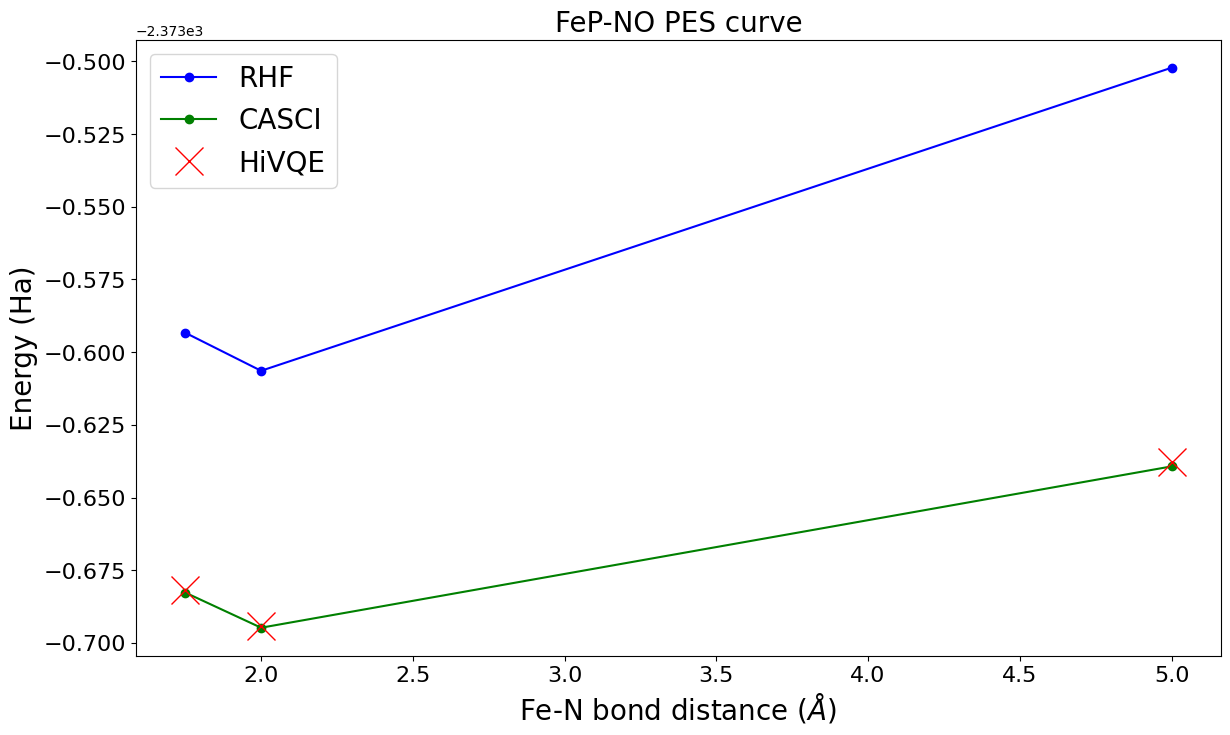

In [ ]:
fig, ax = plt.subplots(1, 1)
hf_energy = [v for key, v in rhf_result.items()]
casci_energy = [v for key, v in casci_result.items()]
hivqe_energy = [v for key, v in hivqe_result.items()]
distance_ref = [float(key) for key, v in rhf_result.items()]
distance = [float(key) for key, v in hivqe_result.items()]

ax.plot(distance_ref, hf_energy, "-o", label="RHF", c="blue")
ax.plot(distance_ref, casci_energy, "-o", label="CASCI", c="green")
ax.plot(distance, hivqe_energy, "x", label="HiVQE", c="red", markersize=20)
ax.legend(fontsize=20)
ax.tick_params("both", labelsize=16)
ax.set_xlabel("Fe-N bond distance ($\AA$)", size=20)
ax.set_ylabel("Energy (Ha)", size=20)
ax.set_title("FeP-NO PES curve", size=20)
fig.set_size_inches(14, 8)

## Tutorial survey

Please take one minute to provide feedback on this tutorial. Your insights will help us improve our content offerings and user experience.

[Link to survey](https://your.feedback.ibm.com/jfe/form/SV_9AizRyKFHEGzVs2)